<a href="https://colab.research.google.com/github/FarahSeif/FarahSeif/blob/main/Labs/lab7/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Transformer-based Sentiment Analysis

![Transformer Sentiment Analysis](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab7/Cover.png?raw=1)

## 4.1 Problem Statement

In this Assignment you will build a transformer encoder **from scratch** to be used as part of a classifier for movie review sentiment analysis on the IMDB dataset.

The full classifier consists of the following 3 main components:
1. Tokenizer: we will use a readily available BERT tokenizer
2. Transformer Encoder: you will implement a transformer encoder from scratch that takes in the outputs of the tokenizer and uses mutli-headed attention blocks and feed forward networks to obtain an output feature representation.
3. Classification Head: we will use a fully connected network that takes the output feature representation from the transformer encoder and obtains the output sentiment prediction using sigmoid activation.

The IMDB dataset consists of a total of 25,000 training examples and 25,000 testing examples with different sentence lengths for the reviews.

We will rely on both quantitative evaluation (using the accuracy metric) and qualitative evaluation (by inspecting the model's output on some test samples and comparing it to the actual output).

**IMPORTANT NOTE:** You have to change runtime type on Google Colab to GPU since this assignment requires much computation resources and it will run very slowly on CPU (Default runtime type)

Click on "Runtime" => "Change runtime type" => make sure that GPU is selected in the "Hardware accelerator"

Now lets walk through the code, and tell you the parts you need to fill.

**MAKE SURE YOU KEEP ALL THE OUTPUTS FOR THE SUBMISSION**

## 4.2 Problem Details

### 4.2.1 Installing and Importing the Needed Packages

Note: You might need to restart your session after running the following cell. **If prompted to do so**, just click restart session and run the cells again. Otherwise, continue running the cells without restarting.

In [1]:
# # Need to install this particular version of tensorflow_text as it allows integrating the BERT tokenizer into the model
# ################################### YOU MIGHT NEED TO RESTART YOUR SESSION AFTER RUNNING THIS CELL ###################################
!pip install --upgrade pip
!pip install --upgrade numpy==1.26.4
!pip install tensorflow==2.15.1 tensorflow-text==2.15.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 28.3 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you 

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.1 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.1


In [1]:
# The datasets package will be used for loading the IMDB dataset
!pip install datasets

In [2]:
!pip install --upgrade pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 26.4 MB/s  0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.


In [3]:
!pip3 install tensorflow-hub

In [4]:
!pip3 install matplotlib

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
# Needed for the tokenizer part of the model
import tensorflow_hub as hub
import tensorflow_text
import tensorflow_text as text  # Required for BERT
from tensorflow.keras.layers import (
    Input, Dense, Embedding, LayerNormalization,
    Dropout, MultiHeadAttention, Add, Flatten
)
from datasets import Dataset, DatasetDict, load_dataset
import matplotlib.pyplot as plt

### 4.2.2 The IMDB Dataset

In this assignment, we will use the [IMDB dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), consisting of 25k training movie reviews and 25k testing movie reviews with a label (0/1) for each review indicating whether it is negative or positive.

Let's load the dataset to the session and inspect it.

#### 4.2.2.1 Loading the dataset

In [6]:
# Load the training and testing datasets
dataset_train = load_dataset("imdb", split = "train")
dataset_test = load_dataset("imdb", split = "test")

# Convert the training dataset to a temporary dataframe to inspect it
# You can use the interactive table option of the dataframe to inspect the dataset as you like
pd.DataFrame.from_dict(dataset_train)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


### 4.2.3 The BERT Tokenizer

Tokenization transforms your raw text data by numerically encoding them based on your vocabulary. This allows a transformer model to understand the input text.

Here we use the BERT tokenizer to obtain the numerical token corresponding to each word in the text, type id values representing the sentence this token belongs to (in our case we have only one input sentence so we should expect all tokens to have a type id of *zero*), and attention masks that allow us to only include the parts of the sentence that contains valid text.

**You can read more about the BERT tokenizer [here](https://www.analyticsvidhya.com/blog/2021/09/an-explanatory-guide-to-bert-tokenizer/).**

In [7]:
# Obtaining the BERT tokenizer from tensorflow_hub
tokenizer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = "tokenizer")

Let's Have a look at the tokenizer in action.

*Now pause for a second and think about the following:*

*   What do the output arrays obtained from the tokenizer: 'input_word_ids', 'input_mask', and 'input_type ids' represent? How will you use them as input to your transformer encoder?
* Why do the output arrays have the same number of elements?
* What do the first and last elements in the 'input_word_ids' array represent?

Note that as this tokenizer is a tensorflow model, we can include it directly as part of our full model regardless of how you implement the transformer encoder.

In [8]:
tokenizer(["this is an amazing movie!"])

{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

### 4.2.4 The Transformer Encoder

<img src="https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab7/Encoder_Abstract.png?raw=1" width="300" height="500">

**The main grading criteria for this part is that your implementation correctly maps the transformer encoder architecture and that it works without errors. For the hyperparameters, you can choose any value you like as long as it allows you to get satisfactory testing accuracy at the end without underfitting/overfitting.**

Here you will implement your transformer encoder.

Your encoder should follow the transformer encoder architecture and should include the following:


*   Word Embeddings and Position Embeddings: you can use Tensorflow's [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer (Note that we don't need the token type embedding since our input consists of a single sentence).
*   Multiple Consecutive Blocks (**at least 2 blocks**) of:
  * Multi-Headed Self-Attention: you can use Tensorflow's [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) layer
  * Skip Connection and Normalization: you can use Tensorflow's [Add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add) and [LayerNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization) layers
  * Intermediate Feed-Forward Network: you can use Tensorflow's [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer
  * Another Skip Connection and Normalization
  * [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers as needed to avoid overfitting

The input of the encoder will be the matrices output by the tokenizer while the output of the encoder will be the output of the feed foward network in the final block.

You can check this [diagram](https://raw.githubusercontent.com/gmihaila/ml_things/master/notebooks/pytorch/bert_inner_workings/bert_inner_workings.png) showcasing the full arctiecture of a BERT encoder model. Use it as a guide when building your own transformer encoder, but don't follow its hyperparameters exactly as the BERT encoder takes a long time to train.

**TODO:** fill in the missing code to define a transformer encoder model.

In [17]:
# --- FIX: Custom Layer to replace hub.KerasLayer ---
# This correctly handles symbolic tensors in Keras 3
class BertPreprocessor(tf.keras.layers.Layer):
    def __init__(self, name="tokenizer", **kwargs):
        super().__init__(name=name, **kwargs)
        # Load the BERT preprocessor model directly
        self.preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

    def call(self, inputs):
        # Ensure operations run on CPU to avoid device placement errors
        with tf.device('/cpu:0'):
            return self.preprocessor(inputs)

# Initialize the tokenizer using the custom layer
tokenizer = BertPreprocessor()

In [16]:
# --- FIX 1: Define a Custom Layer to handle the Hub Preprocessor ---
def get_transformer_encoder(vocab_size=30522, max_len=128):
    # Inputs
    input_word_ids = Input(shape=(None,), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(None,), dtype=tf.int32, name='input_mask')

    # Position indexes
    position_indexes = tf.keras.layers.Lambda(
        lambda x: tf.tile(tf.expand_dims(tf.range(tf.shape(x)[1]), 0), [tf.shape(x)[0], 1])
    )(input_word_ids)

    # Embeddings
    embed_dim = 64
    ff_dim = 128
    num_heads = 4

    word_embedding_layer = Embedding(vocab_size, embed_dim, name="word_embedding")
    positions_embedding_layer = Embedding(max_len, embed_dim, name="pos_embedding")

    embeddings = word_embedding_layer(input_word_ids) + positions_embedding_layer(position_indexes)

    # FIX: Cast input_mask to Boolean for MultiHeadAttention
    # Shape: (batch, 1, seq_len) for broadcasting
    attn_mask = tf.keras.layers.Lambda(lambda x: tf.cast(tf.expand_dims(tf.expand_dims(x, 1), 1), tf.bool))(input_mask)

    # --- Block 1 ---
    attn_output1 = MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim, dropout=0.1
    )(embeddings, embeddings, attention_mask=attn_mask)

    out1 = Add()([embeddings, attn_output1])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ff1 = Dense(ff_dim, activation="relu")(out1)
    ff1 = Dropout(0.1)(ff1)
    ff1 = Dense(embed_dim)(ff1)

    block_output1 = Add()([out1, ff1])
    block_output1 = LayerNormalization(epsilon=1e-6)(block_output1)

    # --- Block 2 ---
    attn_output2 = MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim, dropout=0.1
    )(block_output1, block_output1, attention_mask=attn_mask)

    out2 = Add()([block_output1, attn_output2])
    out2 = LayerNormalization(epsilon=1e-6)(out2)

    ff2 = Dense(ff_dim, activation="relu")(out2)
    ff2 = Dropout(0.1)(ff2)
    ff2 = Dense(embed_dim)(ff2)

    block_output2 = Add()([out2, ff2])
    block_output2 = LayerNormalization(epsilon=1e-6)(block_output2)

    # Output
    encoder_output = Flatten()(block_output2)

    return Model(inputs=[input_word_ids, input_mask], outputs=encoder_output)

### 4.2.5 The Full Classifier Model

Now let's define the full classification model by combining the tokenizer with your implemented transformer encoder model and adding a classification head to the encoder's output.

In [18]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Use custom tokenizer layer
    tokenizer_output = tokenizer(text_input)

    # Extract inputs for encoder
    encoder_inputs = {
        'input_word_ids': tokenizer_output['input_word_ids'],
        'input_mask': tokenizer_output['input_mask'],
    }

    encoder = get_transformer_encoder()
    encoder_outputs = encoder(encoder_inputs)

    output = tf.keras.layers.Dropout(0.2)(encoder_outputs)
    output = tf.keras.layers.Dense(1, activation=None, name='classification_output')(output)

    return tf.keras.Model(text_input, output)

 Take a look at your model's summary. Note the number of parameters and their size in MBs (transformers are large models and require extensive resources for training and storage).

In [19]:
model = build_classifier_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tokenizer           │ [(None, 128),     │          0 │ text[0][0]        │
│ (BertPreprocessor)  │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 8192)      │  2,128,000 │ tokenizer[0][0],  │
│ (Functional)        │                   │            │ tokenizer[0][2]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 8192)      │          0 │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 1)         │      8,193 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,136,193 (8.15 MB)

 Trainable params: 2,136,193 (8.15 MB)

 Non-trainable params: 0 (0.00 B)

Take a look at the model's structure as a diagram.

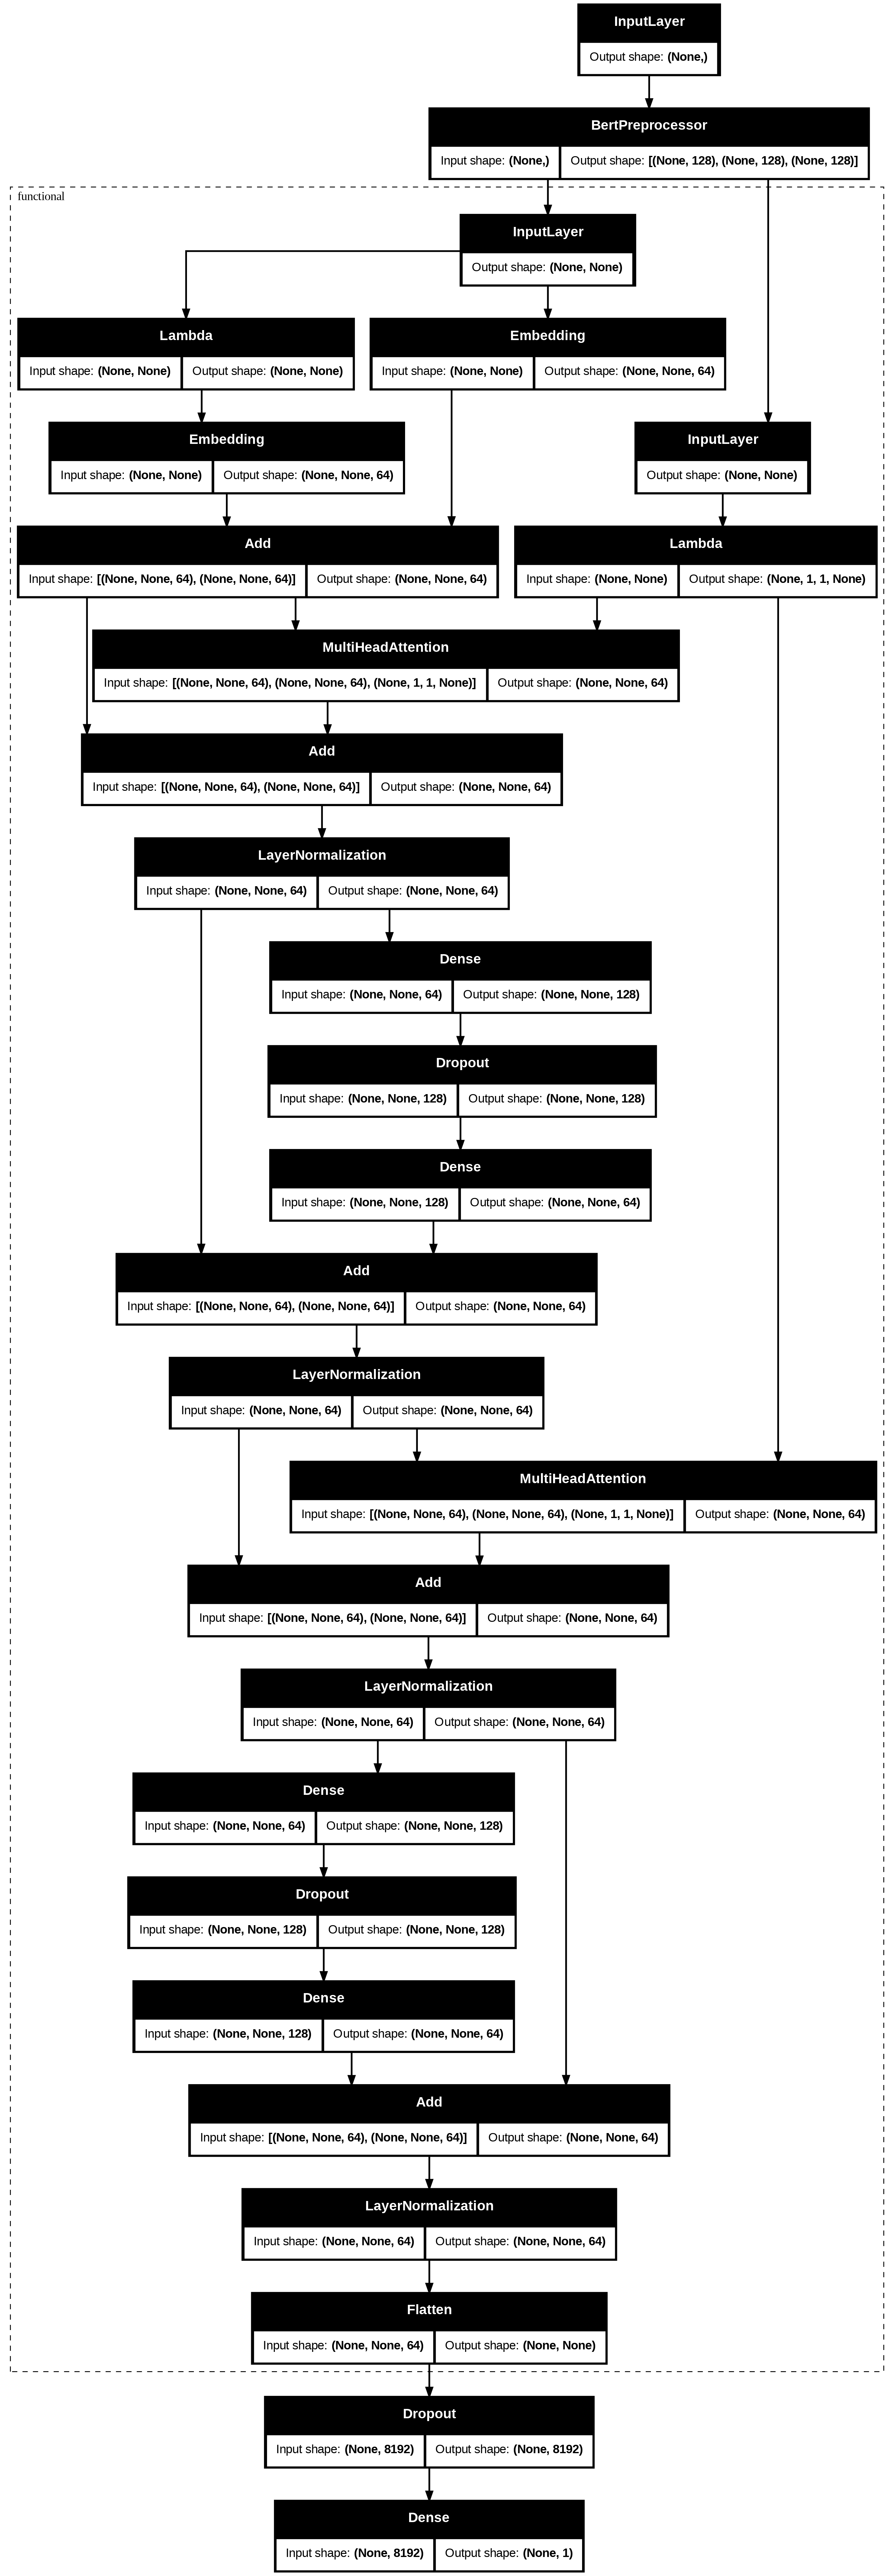

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

### 4.2.6 Training the Model and Performing Quantitative Evaluation

The following function helps us plot the training and validation accuracy and loss after training.

In [21]:
# Plotting the training history
def plot_train_history(hist,
                       metric = 'accuracy'):

  fig = plt.figure(figsize=(10, 5))
  # Get training and test loss histories
  trainingLoss = hist.history['loss']
  valLoss = hist.history['val_loss']

  # Create count of the number of epochs
  epochCount = range(1, len(trainingLoss) + 1)

  # Visualize loss history
  fig.add_subplot(1,2,1)
  plt.plot(epochCount, trainingLoss, 'r--')
  plt.plot(epochCount, valLoss, 'b-')
  plt.legend(['Training Loss', 'Val Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  # Get training and test accuracy histories
  trainingAcc = hist.history[metric]
  valAcc = hist.history['val_' + metric]

  # Create count of the number of epochs
  epoch_count = range(1, len(trainingAcc) + 1)

  # Visualize accuracy history
  fig.add_subplot(1,2,2)
  plt.plot(epoch_count, trainingAcc, 'r--')
  plt.plot(epoch_count, valAcc, 'b-')
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

#### 4.2.6.1 Defining the Training Hyperparameters

In [25]:
# Defining the loss function and the evaluation metric
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# FIX: Wrap the metric in a list brackets [ ... ]
metrics = [tf.metrics.BinaryAccuracy()]

In [23]:
# You are encouraged to experiment with tuning the following hyperparameters to handle overfitting/underfitting
epochs = 15
batch_size = 32
lr = 3e-5
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr)

#### 4.2.6.2 Compiling and Training the Model

In [26]:
# Compiling the model using the loss and evaluation metrics
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

**TODO:** Make sure to handle any underfitting (*training accuracy should at least be more than 90%*) or overfitting in the training. You can try early stopping and/or regularization methods.

In [28]:
# ToDo: Make sure to handle overfitting/underfitting
# 1. Convert the Hugging Face dataset columns to NumPy arrays
# CRITICAL: Use dtype=object for text to handle variable string lengths efficiently
x_train = np.array(dataset_train['text'], dtype=object)
y_train = np.array(dataset_train['label'])

x_test = np.array(dataset_test['text'], dtype=object)
y_test = np.array(dataset_test['label'])

# 2. Run the training using the NumPy arrays
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size)

# 3. Plot the history
#plot_train_history(history, metric='binary_accuracy')
# Running the training and obtaining a plot for it
#history = model.fit(dataset_train['text'],
                    #dataset_train['label'],
                    #validation_data = (dataset_test['text'], dataset_test['label']),
                    #epochs=epochs,
                    #batch_size=batch_size)

#plot_train_history(history, metric = 'binary_accuracy')

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 476s 596ms/step - binary_accuracy: 0.5056 - loss: 0.8399 - val_binary_accuracy: 0.5229 - val_loss: 0.7202
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 504s 600ms/step - binary_accuracy: 0.5427 - loss: 0.7397 - val_binary_accuracy: 0.5412 - val_loss: 0.6892
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 466s 596ms/step - binary_accuracy: 0.6205 - loss: 0.6504 - val_binary_accuracy: 0.7074 - val_loss: 0.5700
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 462s 591ms/step - binary_accuracy: 0.7551 - loss: 0.4890 - val_binary_accuracy: 0.7538 - val_loss: 0.4914
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 457s 584ms/step - binary_accuracy: 0.8320 - loss: 0.3656 - val_binary_accuracy: 0.7843 - val_loss: 0.4741
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 483s 618ms/step - binary_accuracy: 0.8762 - loss: 0.2838 - val_binary_accuracy: 0.7820 - val_loss: 0.4694
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 481s 615ms/step - binary_accuracy: 0.8982 - loss: 0.2401 - val_binary_accuracy: 0.78

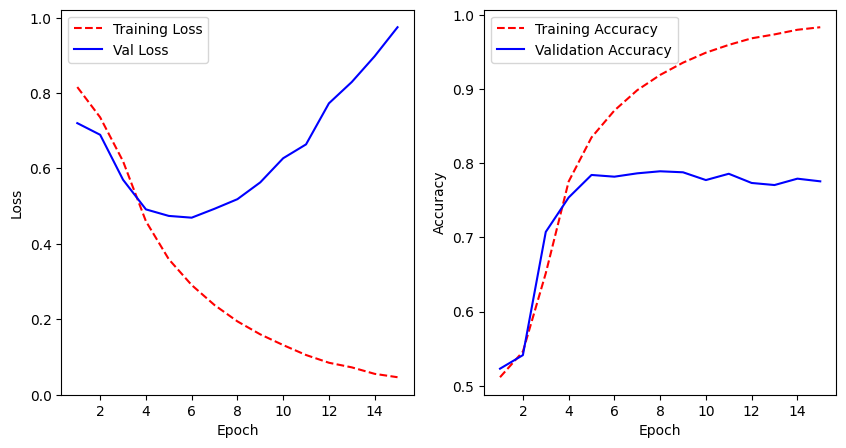

In [30]:
# 3. Plot the history
plot_train_history(history, metric='binary_accuracy')

In [33]:
epochs = 4          # much faster, prevents overfitting
batch_size = 16     # more noise in gradient → better generalization
lr = 3e-4           # 10× higher LR → faster and more stable training

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr,
    weight_decay=1e-4   # OPTIONAL but recommended for Transformers
)
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 520s 333ms/step - binary_accuracy: 0.9923 - loss: 0.0220 - val_binary_accuracy: 0.7681 - val_loss: 1.3103
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 512s 328ms/step - binary_accuracy: 0.9939 - loss: 0.0176 - val_binary_accuracy: 0.7658 - val_loss: 1.3289
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 571s 334ms/step - binary_accuracy: 0.9967 - loss: 0.0101 - val_binary_accuracy: 0.7613 - val_loss: 1.5809
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 502s 321ms/step - binary_accuracy: 0.9955 - loss: 0.0130 - val_binary_accuracy: 0.7382 - val_loss: 1.8147


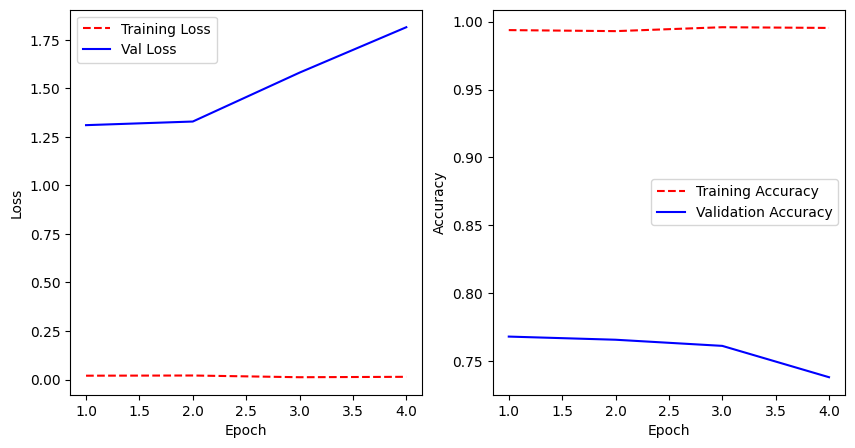

In [34]:
plot_train_history(history, metric='binary_accuracy')

### 4.2.7 Qualitative Evaluation

In [29]:
# This function converts the output model probabiltiy into a sentiment (Positive or Negative)
def get_sentiment(probability_positive):
  if probability_positive > 0.5:
    return "Positive"
  else:
    return "Negative"

Let's check the model's output compared to random review samples from the testing data. You can run the following cell multiple times to see different examples!

In [31]:
# Randomly select a test review and check the model's output on it
# You can run it multiple times to check different samples
# After running this cell, keep your output
for i in range(10):
  random_id = np.random.randint(0, len(dataset_test))
  test_review = dataset_test['text'][random_id]
  test_label = dataset_test['label'][random_id]
  print("Review: ", test_review)
  print("Ground Truth Sentiment: ", get_sentiment(test_label))
  # Prediction probability of the Positive review, i.e., 1 using sigmoid function:
  probability_positive = 1/(1 + np.exp(-model.predict([test_review], verbose = 0)[0][0]))
  probability_negative = 1 - probability_positive
  print("Predicted Sentiment: ", get_sentiment(probability_positive))
  print("Prediction Probability: Positive({}), Negative({})".format(probability_positive, probability_negative))
  print("-"*200)

Review:  It is difficult to imagine how the engaging Dan Brown novel "Angels and Demons" could misfire as badly as this film version. Here are ten reasons why the film was a failure. Due to the spoilers, please do no read on unless you have already seen the film.<br /><br />(1) In the film, there was no love relationship between Robert Langdon and Vittoria Vetra. Worse still, there was not even any chemistry between the two leading actors. <br /><br />(2) The breathtaking locations in Rome, as described in the novel, were not realized visually in the film. I am aware that director Ron Howard encountered difficulties in filming on location. But there are superior photographed depictions of Rome on The History Channel than in this film where the Eternal City was presented in eternal stock film footage. The great art works described in the novel were only briefly depicted in the film. The magnificent Bernini sculpture of the "Ecstasy of St. Teresa" was only momentarily glimpsed, and the W

ValueError: Unrecognized data type: x=['It is difficult to imagine how the engaging Dan Brown novel "Angels and Demons" could misfire as badly as this film version. Here are ten reasons why the film was a failure. Due to the spoilers, please do no read on unless you have already seen the film.<br /><br />(1) In the film, there was no love relationship between Robert Langdon and Vittoria Vetra. Worse still, there was not even any chemistry between the two leading actors. <br /><br />(2) The breathtaking locations in Rome, as described in the novel, were not realized visually in the film. I am aware that director Ron Howard encountered difficulties in filming on location. But there are superior photographed depictions of Rome on The History Channel than in this film where the Eternal City was presented in eternal stock film footage. The great art works described in the novel were only briefly depicted in the film. The magnificent Bernini sculpture of the "Ecstasy of St. Teresa" was only momentarily glimpsed, and the West Ponente relief in Vatican Square was not visible at all.<br /><br />(3) The most tasteless choice made by the film-maker was in the depiction of the deceased pope who actually resembled the beloved John Paul II. In the novel, the pope is clearly fictional with no resemblance to any real pope.<br /><br />(4) One of the most colorful (and important) characters of the novel, Maximilian Kohler, Director of CERN, was cut out of the screenplay.<br /><br />(5) There were numerous instances when the lines of dialog were inaudible due to extraneous background noise.<br /><br />(6) There were moments when the faces of characters were not visible due to the shadows and chiaroscuro film lighting. This technique worked in "The Godfather" films, but Ron Howard is no Gordon Willis.<br /><br />(7) The College of Cardinals was quite a motley crew with one of the electors speaking in a Southern drawl. This dude would have been more at home on a Texas ranch than in the Sistine Chapel.<br /><br />(8) The crucial relationship of the Camerlengo and the deceased Pope was not defined in the film. This relationship was central to the theme of science vs. religion and the relevance of the Illuminati to the plot against the church.<br /><br />(9) In the novel, the character of Hassassin was an unforgettable villain. In the film, that assassin character\'s role was a cardboard cutout villain. <br /><br />(10) As a whole, the filmmakers did not trust the workings of the successful novel.<br /><br />In the novel, Langdon makes an impossible fall out of the sky and into the Tiber River. In Ron Howard\'s film, it was the movie itself that landed in the Tiber.'] (of type <class 'list'>)

## 4.3 Conclusion

That's it! Congratulations on training a transformer-based sentiment analysis model.

Make sure you deliver all the requirements for the submission and to keep the outputs in the notebook!